In [1]:
"""
Auto Forecast:
    - large collections of univariate time series
    - ARIMA, ETS, Theta, CES
Exponential Smoothing:
    - data with no clear trend or seasonality
    - SES, Holt's Winters, SSO
Benchmark models:
    - Mean, Navie, Random Walk
Intermittent or Sparse models:
    - series with very few non-zero observations
    - CROSTON, ADIDA, IMAPA
Multiple Seasonalities:
    - signals with more than one clear seasonality
    - low-frequency data
    - MSTL
Theta Models:
    - deseasonalized time series
    - Theta, DynamicTheta
"""

"\nAuto Forecast:\n    - large collections of univariate time series\n    - ARIMA, ETS, Theta, CES\nExponential Smoothing:\n    - data with no clear trend or seasonality\n    - SES, Holt's Winters, SSO\nBenchmark models:\n    - Mean, Navie, Random Walk\nIntermittent or Sparse models:\n    - series with very few non-zero observations\n    - CROSTON, ADIDA, IMAPA\nMultiple Seasonalities:\n    - signals with more than one clear seasonality\n    - low-frequency data\n    - MSTL\nTheta Models:\n    - deseasonalized time series\n    - Theta, DynamicTheta\n"

In [2]:
# tools
import os
import pandas as pd
import matplotlib.pyplot as plt
import multiprocessing as mp

# forecast
from statsforecast import StatsForecast

# models
from statsforecast.models import (
    HoltWinters,
    CrostonClassic as Croston,
    HistoricAverage,
    DynamicOptimizedTheta as DOT,
    SeasonalNaive,
)

# evaluation
from utilsforecast.losses import mse

os.environ["NIXTLA_ID_AS_COL"] = "1"
os.environ["NUMBA_NUM_THREADS"] = "1"

# data

In [3]:
def load_data():
    # data read
    Y_df = pd.read_parquet("https://datasets-nixtla.s3.amazonaws.com/m4-hourly.parquet")
    # data filter
    uids = Y_df["unique_id"].unique()[:10]
    Y_df = Y_df.query("unique_id in @uids")
    Y_df = Y_df.groupby("unique_id").tail(7 * 24)

    return Y_df


Y_df = load_data()
print(Y_df.head(), "\n")
print(Y_df.tail(), "\n")
print(Y_df.shape, "\n")
print(Y_df["unique_id"].value_counts())

    unique_id   ds      y
580        H1  581  587.0
581        H1  582  537.0
582        H1  583  492.0
583        H1  584  464.0
584        H1  585  443.0 

     unique_id   ds       y
7475      H107  744  4316.0
7476      H107  745  4159.0
7477      H107  746  4058.0
7478      H107  747  3971.0
7479      H107  748  3770.0 

(1680, 3) 

unique_id
H1      168
H10     168
H100    168
H101    168
H102    168
H103    168
H104    168
H105    168
H106    168
H107    168
Name: count, dtype: int64


# EDA

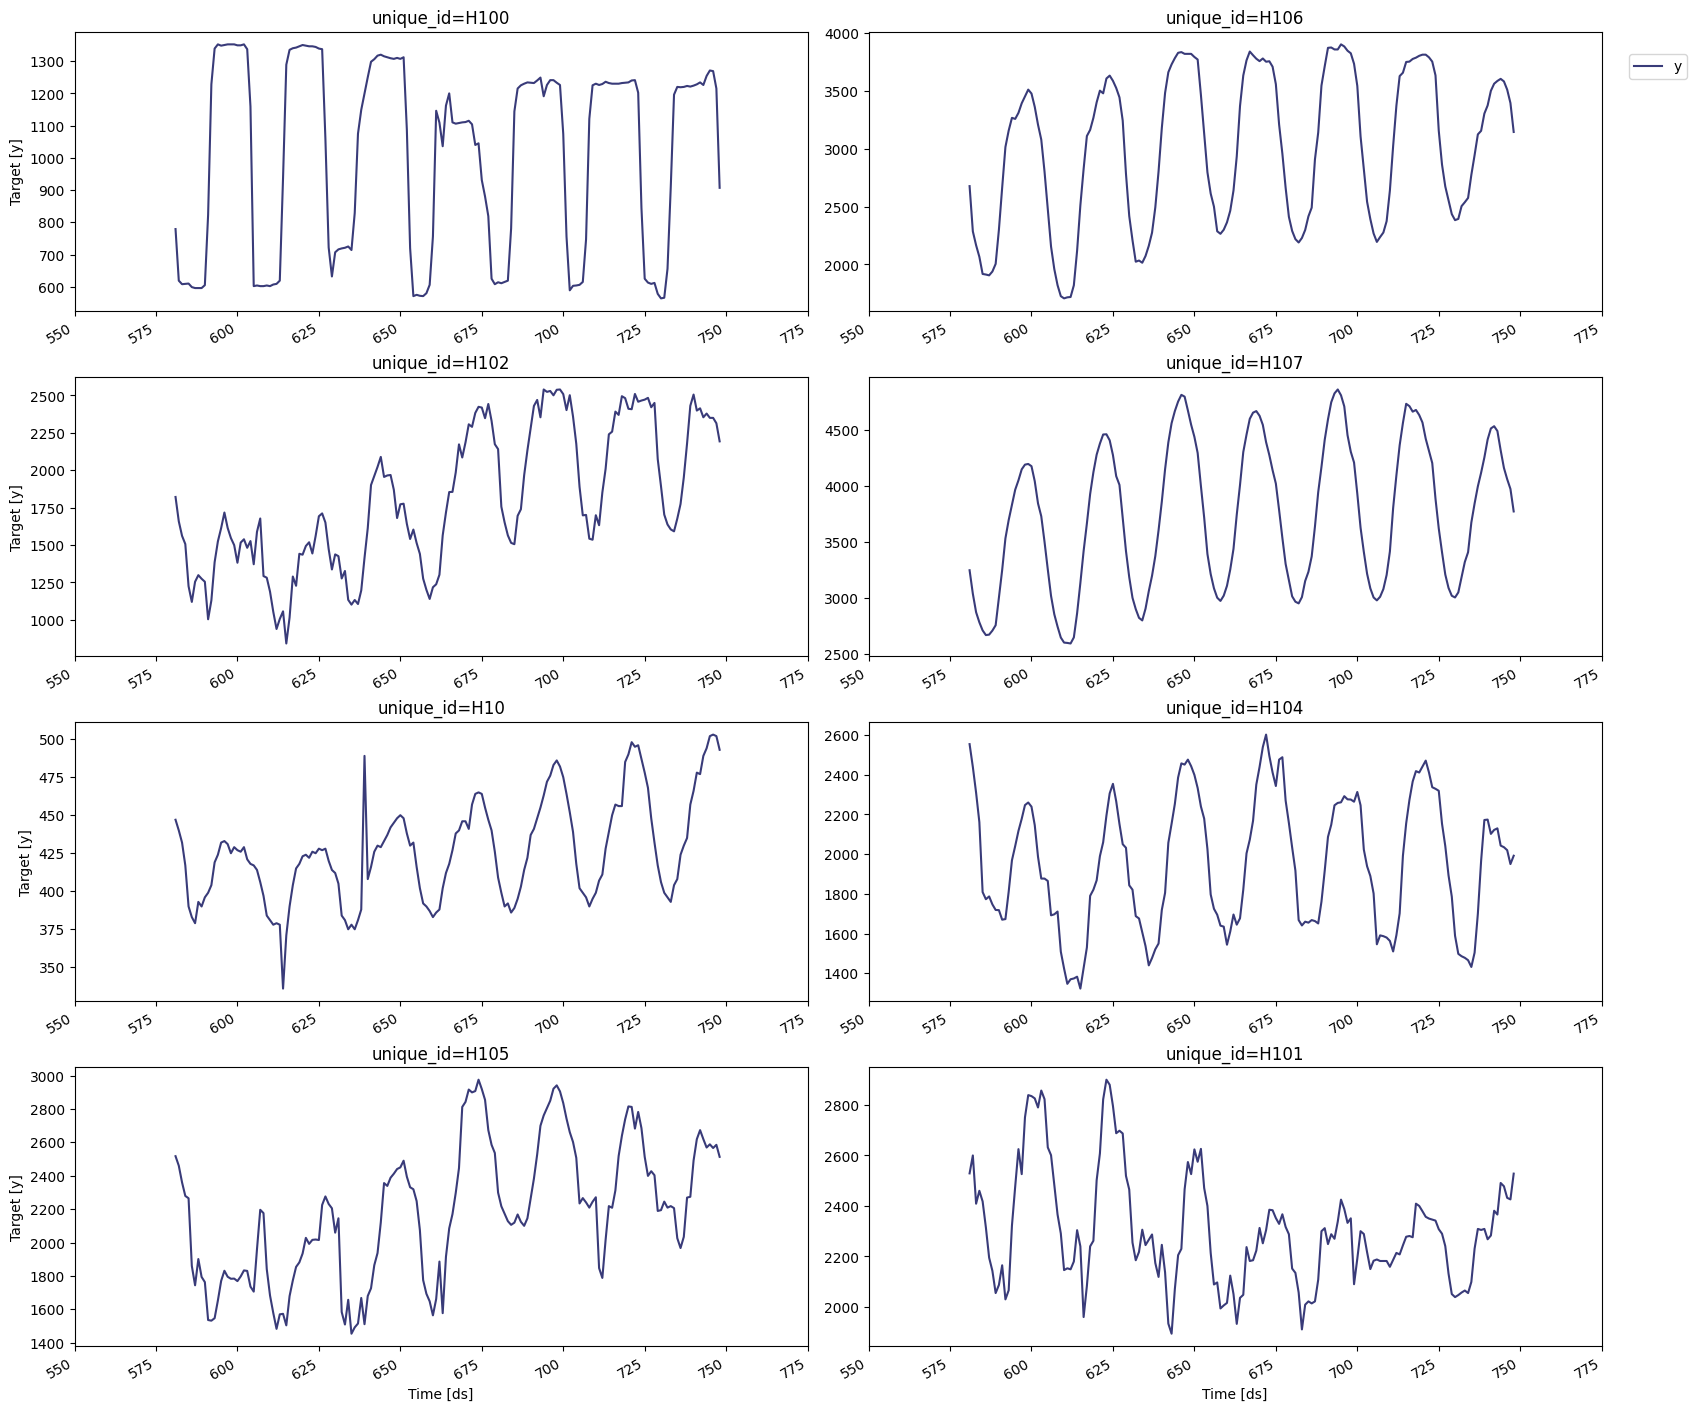

In [5]:
StatsForecast.plot(Y_df, engine="matplotlib")

# model

In [18]:
models = [
    HoltWinters(),
    Croston(),
    SeasonalNaive(season_length=24),
    HistoricAverage(),
    DOT(season_length=24),
]
sf = StatsForecast(
    models = models,
    freq = 1,
    fallback_model=SeasonalNaive(season_length=7),
    n_jobs = -1,
)

# model training & predicting

In [19]:
# sf.fit(Y_df)

# preds_df = sf.predict(h = 48)
# preds_df

# model evluation

In [22]:
forecasts_df = sf.forecast(df = Y_df, h = 48, level = [90])
print(forecasts_df.head(), "\n")
print(forecasts_df.shape, "\n")
print(forecasts_df["unique_id"].value_counts())

  unique_id   ds  HoltWinters  HoltWinters-lo-90  HoltWinters-hi-90  \
0        H1  749        829.0        -246.367554        1904.367554   
1        H1  750        807.0        -268.367554        1882.367554   
2        H1  751        785.0        -290.367554        1860.367554   
3        H1  752        756.0        -319.367554        1831.367554   
4        H1  753        719.0        -356.367554        1794.367554   

   CrostonClassic  CrostonClassic-lo-90  CrostonClassic-hi-90  SeasonalNaive  \
0           829.0           -246.367554           1904.367554          635.0   
1           807.0           -268.367554           1882.367554          572.0   
2           785.0           -290.367554           1860.367554          532.0   
3           756.0           -319.367554           1831.367554          493.0   
4           719.0           -356.367554           1794.367554          477.0   

   SeasonalNaive-lo-90  SeasonalNaive-hi-90  HistoricAverage  \
0           537.471191      

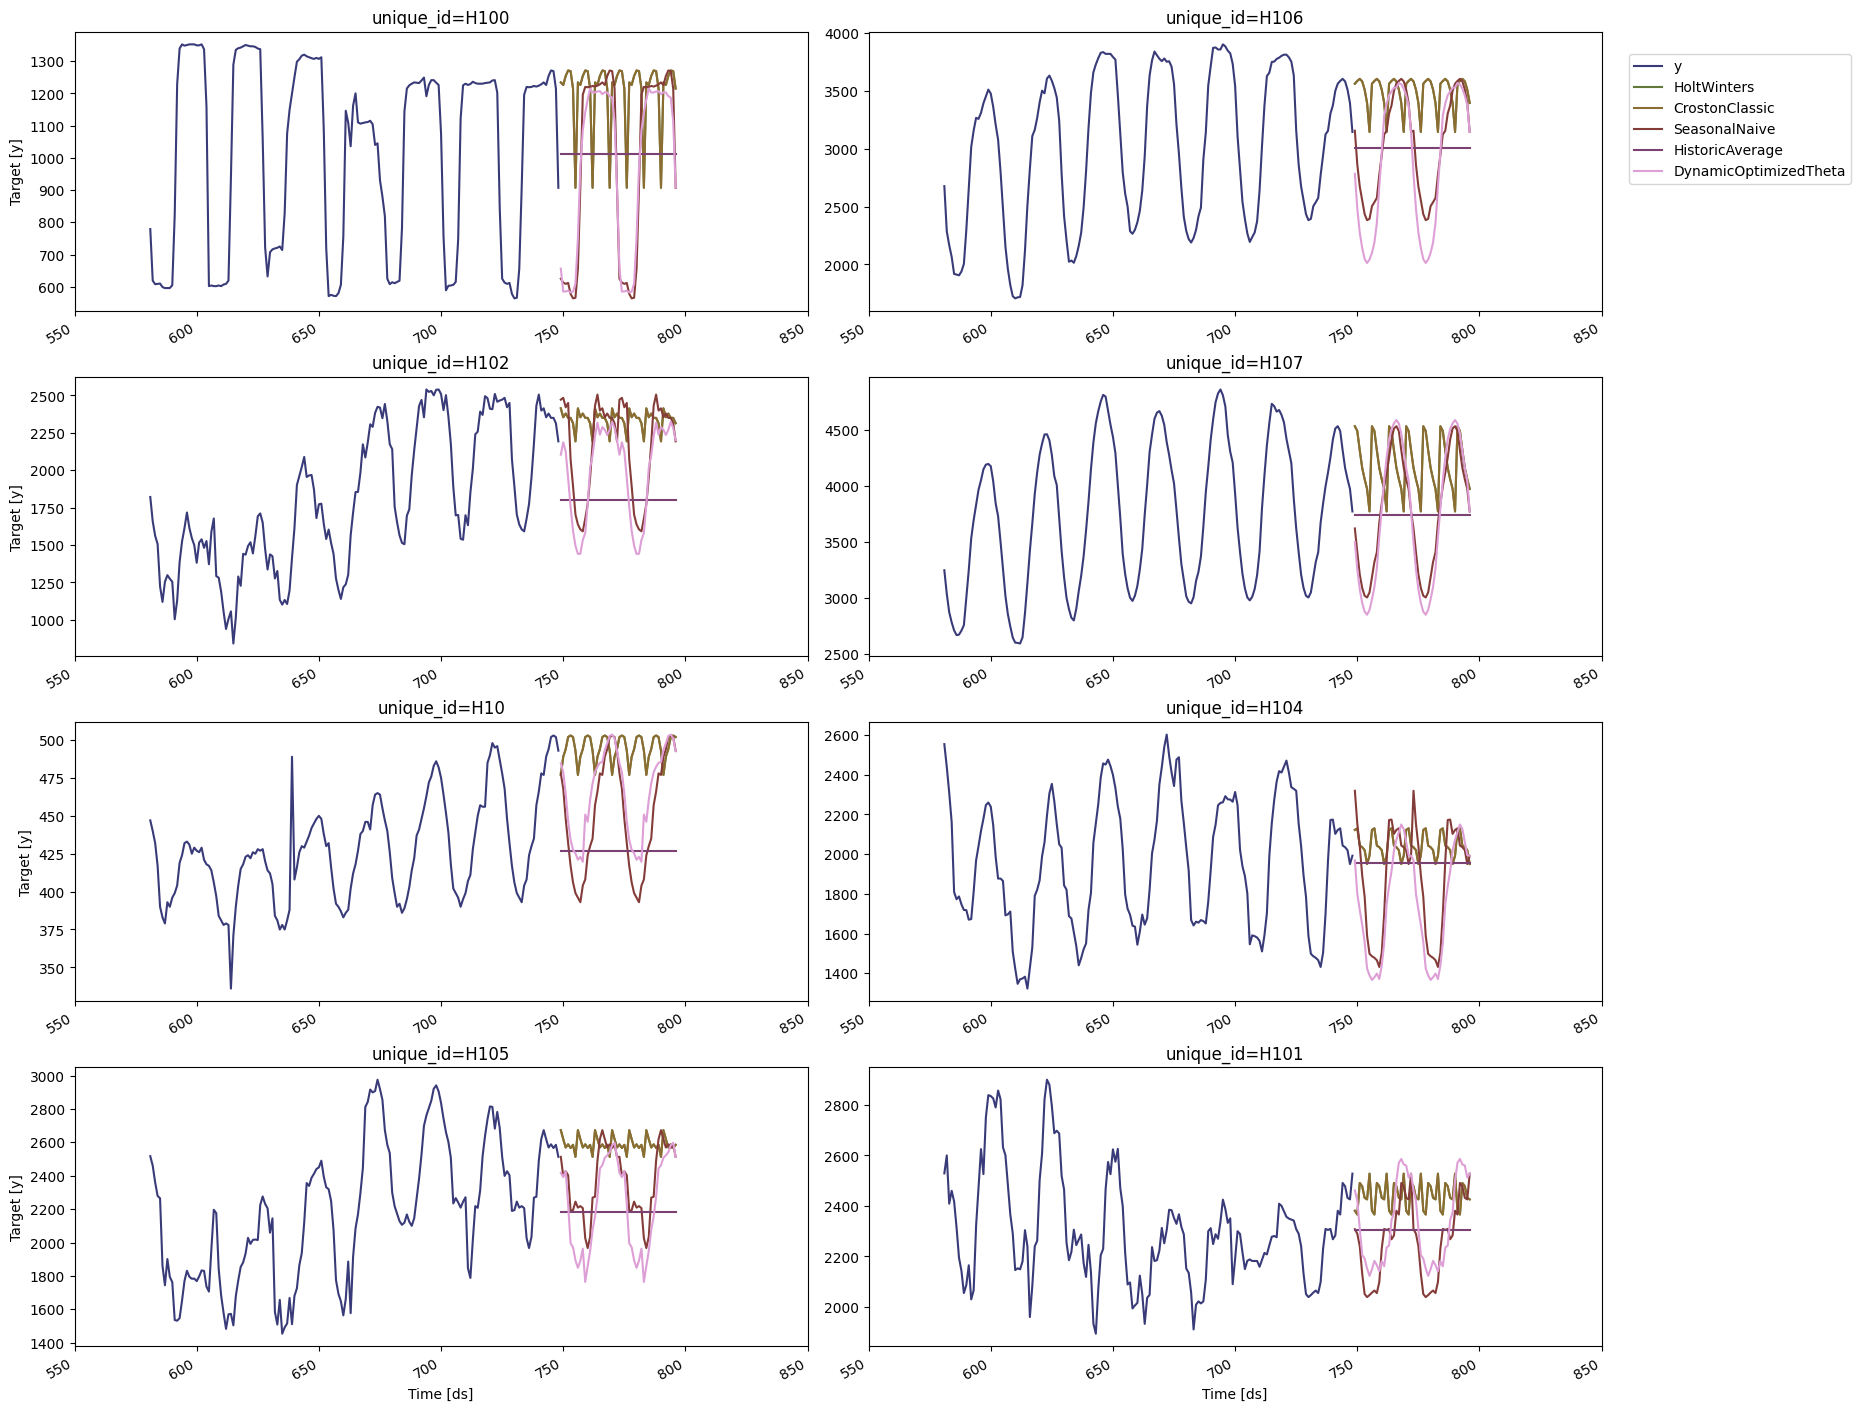

In [23]:
sf.plot(Y_df, forecasts_df)

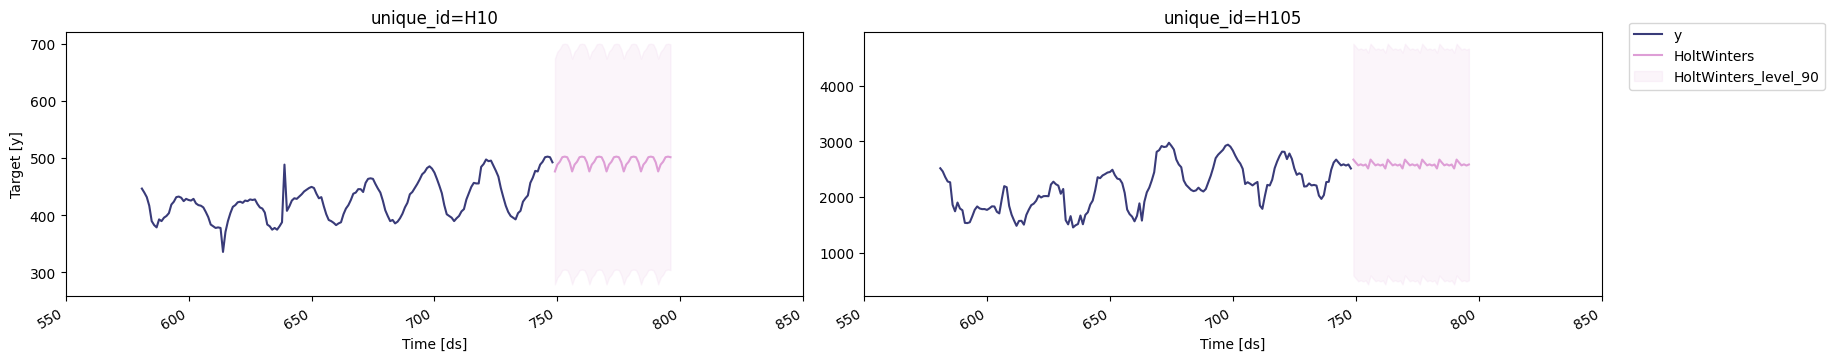

In [24]:
sf.plot(
    Y_df, 
    forecasts_df, 
    models = [str(sf.models[0])], 
    unique_ids = ["H10", "H105"], 
    level = [90]
)

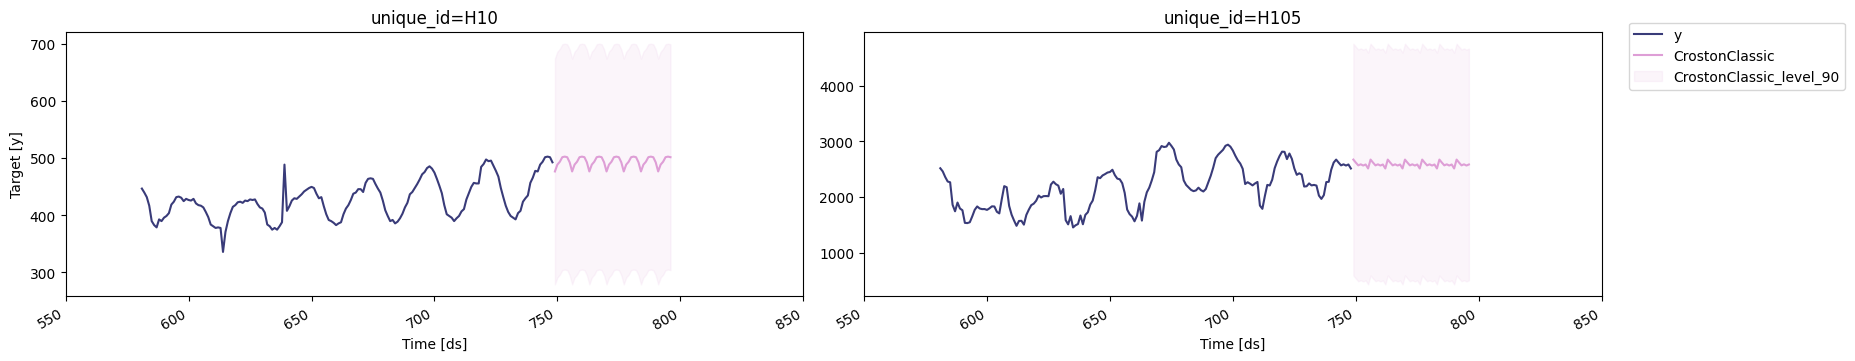

In [25]:
sf.plot(
    Y_df, 
    forecasts_df, 
    models = [str(sf.models[1])],
    unique_ids = ["H10", "H105"], 
    level = [90]
)

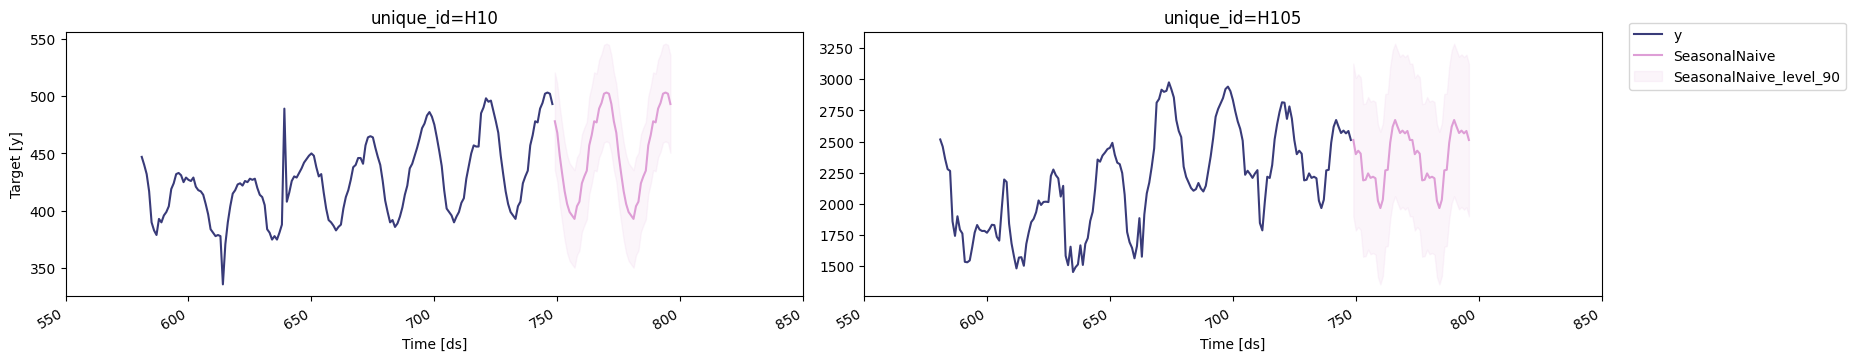

In [26]:
sf.plot(
    Y_df, 
    forecasts_df, 
    models = [str(sf.models[2])],
    unique_ids = ["H10", "H105"], 
    level = [90]
)

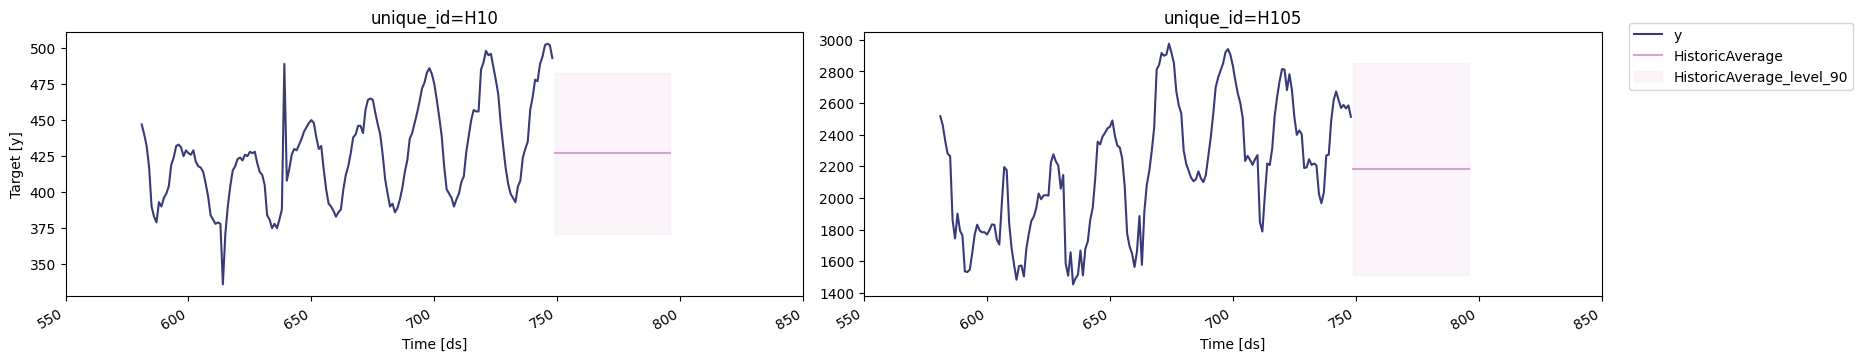

In [27]:
sf.plot(
    Y_df, 
    forecasts_df, 
    models = [str(sf.models[3])],
    unique_ids = ["H10", "H105"], 
    level = [90]
)

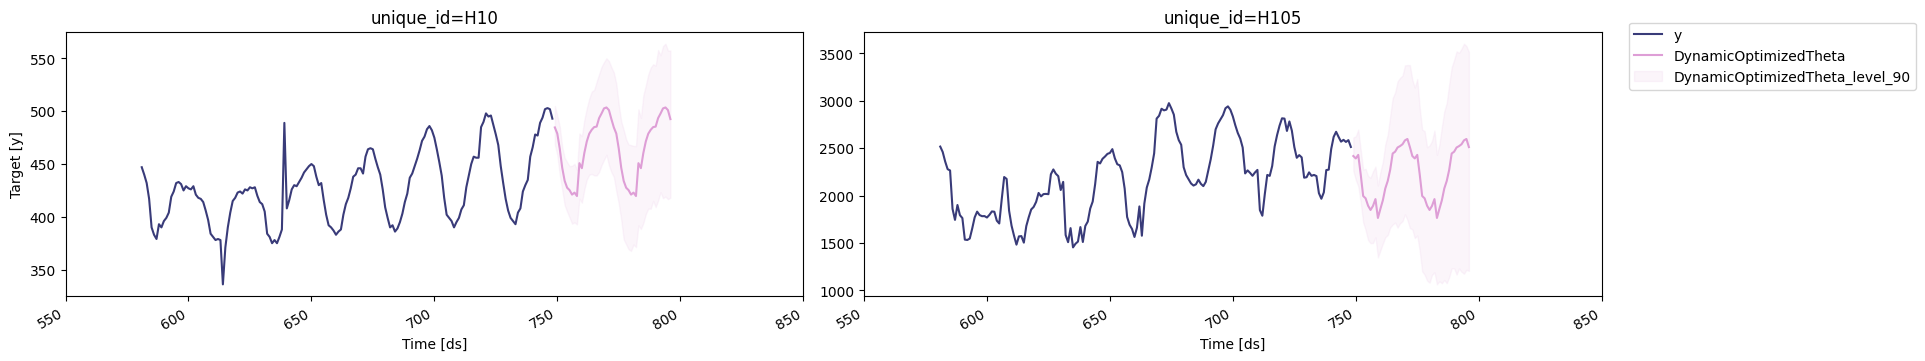

In [28]:
sf.plot(
    Y_df, 
    forecasts_df, 
    models = [str(sf.models[4])],
    unique_ids = ["H10", "H105"], 
    level = [90]
)

# cross validation

In [29]:
cv_df = sf.cross_validation(
    df = Y_df,
    h = 24,
    step_size = 24,
    n_windows = 2,
)
print(cv_df.head(), "\n")
print(cv_df.shape, "\n")
print(cv_df["unique_id"].value_counts())

  unique_id   ds  cutoff      y  HoltWinters  CrostonClassic  SeasonalNaive  \
0        H1  701     700  619.0        847.0      742.668762          691.0   
1        H1  702     700  565.0        820.0      742.668762          618.0   
2        H1  703     700  532.0        790.0      742.668762          563.0   
3        H1  704     700  495.0        784.0      742.668762          529.0   
4        H1  705     700  481.0        752.0      742.668762          504.0   

   HistoricAverage  DynamicOptimizedTheta  
0       661.674988             612.767517  
1       661.674988             536.846252  
2       661.674988             497.824280  
3       661.674988             464.723236  
4       661.674988             440.972351   

(480, 9) 

unique_id
H1      48
H10     48
H100    48
H101    48
H102    48
H103    48
H104    48
H105    48
H106    48
H107    48
Name: count, dtype: int64


In [39]:
cv_df["cutoff"].value_counts().to_frame().reset_index()

,cutoff,count
0,700,240
1,724,240


In [36]:
def evaluate_cv(df, metric):
    models = df.columns.drop(['unique_id', 'ds', 'y', 'cutoff']).tolist()
    evals = metric(df, models=models)
    evals['best_model'] = evals[models].idxmin(axis=1)
    return evals

evaluation_df = evaluate_cv(cv_df, mse)
evaluation_df

,unique_id,HoltWinters,CrostonClassic,SeasonalNaive,HistoricAverage,DynamicOptimizedTheta,best_model
0,H1,4.488802e+04,2.803874e+04,1.422667e+03,2.092767e+04,1.296334e+03,DynamicOptimizedTheta
1,H10,2.812917e+03,1.483484e+03,9.689584e+01,1.980368e+03,3.796211e+02,SeasonalNaive
2,H100,1.216254e+05,9.194515e+04,1.201900e+04,7.849120e+04,2.169965e+04,SeasonalNaive
3,H101,2.845340e+04,1.618363e+04,1.094446e+04,1.820840e+04,6.369808e+04,SeasonalNaive
4,H102,2.329249e+05,1.326553e+05,1.269990e+04,3.091105e+05,3.139352e+04,SeasonalNaive
5,H103,6.479682e+08,3.953472e+08,6.764138e+07,2.720892e+08,2.288080e+07,DynamicOptimizedTheta
6,H104,2.743456e+05,1.511467e+05,3.213485e+04,1.039119e+05,3.210866e+04,DynamicOptimizedTheta
7,H105,2.352914e+05,9.948973e+04,2.192912e+04,1.394961e+05,2.646612e+04,SeasonalNaive
8,H106,7.832138e+05,4.615086e+05,4.741539e+04,3.123601e+05,1.234877e+05,SeasonalNaive
9,H107,8.308352e+05,4.726734e+05,2.841752e+04,3.611299e+05,1.855117e+04,DynamicOptimizedTheta


In [36]:
evaluation_df['best_model'].value_counts().to_frame().reset_index()

,best_model,count
0,SeasonalNaive,6
1,DynamicOptimizedTheta,4


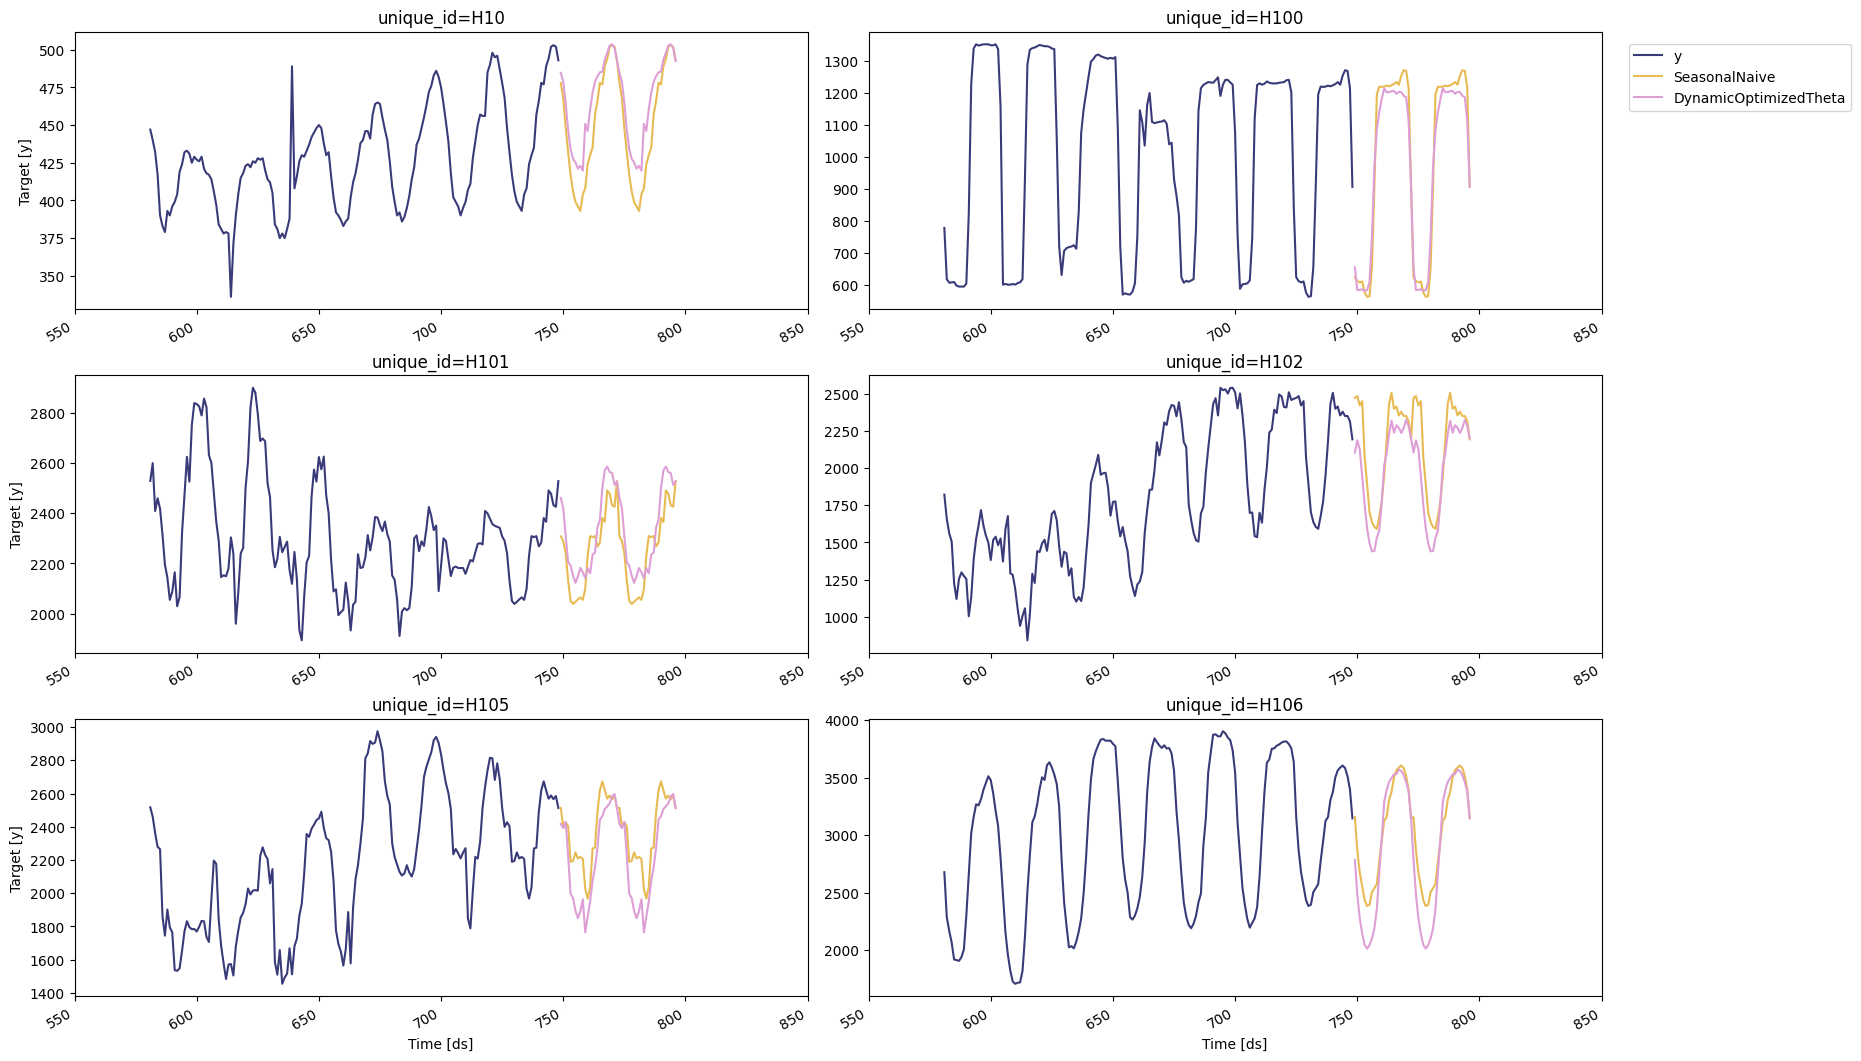

In [37]:
seasonal_ids = evaluation_df.query('best_model == "SeasonalNaive"')['unique_id']
sf.plot(
    Y_df,
    forecasts_df, 
    unique_ids = seasonal_ids, 
    models = ["SeasonalNaive","DynamicOptimizedTheta"]
)

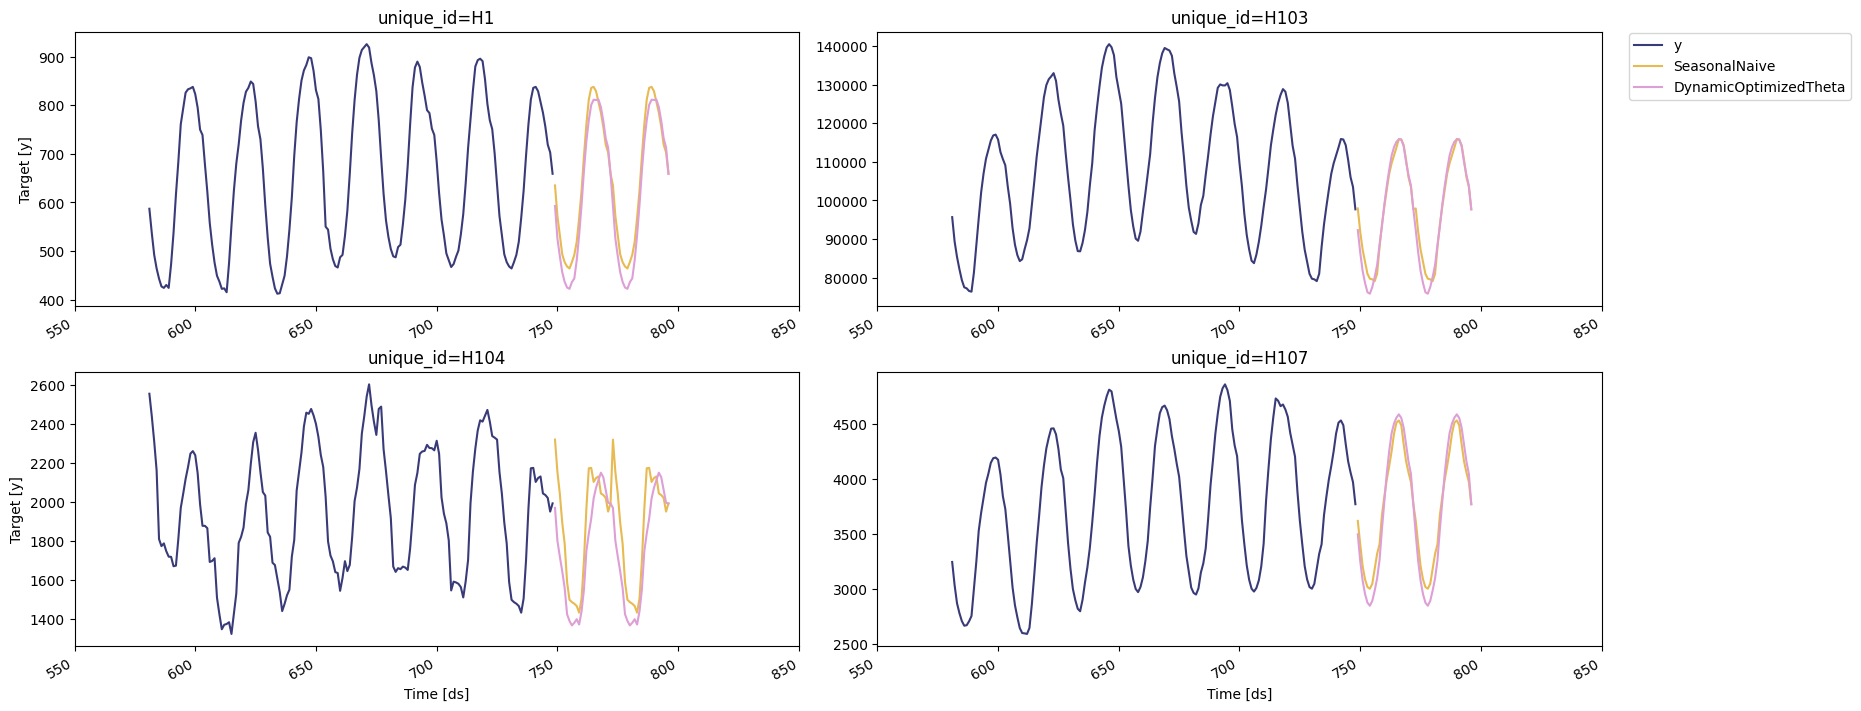

In [40]:
theta_ids = evaluation_df.query('best_model == "DynamicOptimizedTheta"')['unique_id']
sf.plot(
    Y_df,
    forecasts_df, 
    unique_ids = theta_ids, 
    models = ["SeasonalNaive","DynamicOptimizedTheta"]
)

# model selection